In [2]:
import gym
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

import numpy as np
import matplotlib.pyplot as plt

\begin{equation}
\begin{split}
J(\theta) 
&= \mathbb E\left[\sum_{a \in \mathcal A}q(s_t,a)\pi_\theta(a | s_t)\right] \\
\nabla J(\theta) 
&= \mathbb E\left[\sum_{a \in \mathcal A}q(s_t,a)\nabla\pi_\theta(a | s_t)\right] \\
&= \mathbb E\left[\sum_{a \in \mathcal A}\pi_\theta(a | s_t)q(s_t,a)\frac{\nabla\pi_\theta(a | s_t)}{\pi_\theta(a | s_t)}\right] \\
&= \mathbb E\left[q(s_t,a_t)\frac{\nabla\pi_\theta(a_t | s_t)}{\pi_\theta(a_t | s_t)}\right] \\
&= \mathbb E\left[q(s_t,a_t)\nabla\log\pi_\theta(a_t | s_t)\right] \\
&= \mathbb E\left[\mathbb E \left[G_t | s_t, a_t \right]\nabla\log\pi_\theta(a_t | s_t)\right] \\
&= \mathbb E\left[G_t\nabla\log\pi_\theta(a_t | s_t)\right] \\
&= \nabla \mathbb E\left[G_t\log\pi_\theta(a_t | s_t)\right] \\
\end{split}
\end{equation}

We replace the sum over all possible actions by an expectation over $a_t \sim \pi_\theta$.
Thus, we can rewrite our objective as 

\begin{equation}
J(\theta) = \mathbb E\left[G_t\log\pi_\theta(a_t | s_t)\right]
\end{equation}

running reward: 9.13 at episode 10
running reward: 16.48 at episode 20
running reward: 17.58 at episode 30
running reward: 20.43 at episode 40
running reward: 35.60 at episode 50
running reward: 63.66 at episode 60
running reward: 80.18 at episode 70
running reward: 87.53 at episode 80
running reward: 74.96 at episode 90
running reward: 66.77 at episode 100
running reward: 61.61 at episode 110
running reward: 75.02 at episode 120
running reward: 110.22 at episode 130
running reward: 137.67 at episode 140
running reward: 137.87 at episode 150
running reward: 152.22 at episode 160
running reward: 169.64 at episode 170
Solved at episode 179!


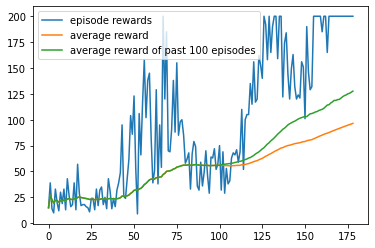

In [19]:
env = gym.make('CartPole-v0')
gamma = 0.99

input_dim  = 4
action_dim = 2
hidden_dim = 128 

class AgentNetwork(tf.keras.Model):
    
    def __init__(self, action_dim, hidden_dim):
        super().__init__()
        
        self.hidden = layers.Dense(hidden_dim, activation='relu')
        self.actor  = layers.Dense(action_dim, activation='softmax')
        self.critic = layers.Dense(1)
        
    def call(self, inputs):
        # actor and critic share the same hidden layer
        x = self.hidden(inputs)
        return self.actor(x), self.critic(x)
    
adam_optimizer = keras.optimizers.Adam(learning_rate=0.003)
huber_loss = keras.losses.Huber()
model = AgentNetwork(2, 128)

MAX_EPISODE_LENGTH = 1000
eps = 0.1

def run_episode(env, state):
    
    action_prob_history  = []
    critic_value_history = []
    reward_history       = []
    
    for step in range(1, MAX_EPISODE_LENGTH):
        state = tf.convert_to_tensor([state])
        
        action_probs, critic_value = model(state)
        action_index = np.random.choice(action_dim, p=np.squeeze(action_probs))
        
        action_prob_history.append(action_probs[0, action_index])
        critic_value_history.append(critic_value[0,0])
        
        state, reward, done, _ = env.step(action_index)
        reward_history.append(reward)
        
        if done:
            break
        
    return action_prob_history, critic_value_history, reward_history

def compute_returns(rewards_history):
    returns = [None] * len(rewards_history) 
    discounted_sum = 0

    for i in range(len(rewards_history)-1, -1, -1):
        discounted_sum = rewards_history[i] + gamma*discounted_sum
        returns[i] = discounted_sum
        
    return returns
        
def compute_loss(action_probs_history, critic_value_history, returns):
    
    history = zip(action_probs_history, critic_value_history, returns)
    actor_losses = []
    critic_losses = []

    for action_prob, value, ret in history:
        advantage = ret - value
        loss = tf.math.log(action_prob) * advantage # J(\theta)
        actor_losses.append(loss)
        critic_losses.append(huber_loss(tf.expand_dims(value, 0), tf.expand_dims(ret, 0)))
    
    return sum(actor_losses) + sum(critic_losses)


# @tf.function
def train_step(init_state, model, optimizer, gamma):
    with tf.GradientTape() as tape:

        # generate trajectory
        action_probs_history, critic_value_history, reward_history = run_episode(env, init_state)

        # compute the returns at each state in the trajectory
        returns = compute_returns(reward_history)
        
        # compute loss = J(\theta)
        loss_value = compute_loss(action_probs_history, critic_value_history, returns)

        # compute gradient of loss.
        # Use negative loss_value because optimizer.apply_gradients() performs gradient 
        # *descent* (minimization) whereas we want to perform gradient *ascent* (maximization)
        grads = tape.gradient(-loss_value, model.trainable_variables)
        
        # apply gradient update to \theta. 
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        # compute return from this episode just so we can plot it.
        episode_reward = tf.math.reduce_sum(reward_history)
        
        return episode_reward
    
def train():
    
    episode_count = 0
    running_reward = 0
    episode_rewards = []
    
    while True:

        init_state = env.reset()
        episode_reward = train_step(init_state, model, adam_optimizer, gamma)
        episode_rewards.append(episode_reward)
        
        running_reward = 0.05 * episode_reward + (1 - 0.05) * running_reward
        
        # Log details
        episode_count += 1
        if episode_count % 10 == 0:
            template = "running reward: {:.2f} at episode {}"
            print(template.format(running_reward, episode_count))
        if running_reward > 180:  # Condition to consider the task solved
            print("Solved at episode {}!".format(episode_count))
            break
        
        

    plt.plot(episode_rewards, label='episode rewards')
    
    running_avg = [np.average(episode_rewards[:i+1]) for i in range(len(episode_rewards))]
    running_avg_100 = running_avg[:100] + [np.average(episode_rewards[i:i+100]) for i in range(len(episode_rewards)-100)]
    
    plt.plot(running_avg, label='average reward')
    plt.plot(running_avg_100, label='average reward of past 100 episodes')
    plt.legend()
    plt.show()
    
train()

In [9]:
import gym
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

import numpy as np
import matplotlib.pyplot as plt

env = gym.make('CartPole-v0')

class EpisodeHistory():
    
    def __init__(self):
        self.action_prob_history  = []
        self.critic_value_history = []
        self.reward_history       = []
        
    def append(self, action_prob, critic_value, reward):
        self.action_prob_history.append(action_prob)
        self.critic_value_history.append(critic_value)
        self.reward_history.append(reward)
        
    def clear(self):
        self.action_prob_history.clear()
        self.critic_value_history.clear()
        self.reward_history.clear()

class AgentNetworkShared(tf.keras.Model):
    
    def __init__(self, action_dim=2, hidden_dim=128):
        super().__init__()
        
        self.action_dim = action_dim
        self.hidden_dim = hidden_dim
        
        self.hidden = layers.Dense(self.hidden_dim, activation='relu')
        self.actor  = layers.Dense(self.action_dim, activation='softmax')
        self.critic = layers.Dense(1)
        self.history = EpisodeHistory()
        
    def call(self, inputs):
        x = self.hidden(inputs)
        return self.actor(x), self.critic(x)
    
class AgentNetworkSeparated(tf.keras.Model):
    
    def __init__(self, action_dim=2, hidden_dim=128):
        super().__init__()
        
        self.action_dim = action_dim
        self.hidden_dim = hidden_dim
        
        self.hidden_actor = layers.Dense(self.hidden_dim, activation='relu')
        self.actor  = layers.Dense(self.action_dim, activation='softmax')
        
        self.hidden_critic = layers.Dense(self.hidden_dim, activation='relu')
        self.critic = layers.Dense(1)
        
        self.history = EpisodeHistory()
        
    def call(self, inputs):
        x_actor  = self.hidden_actor(inputs)
        x_critic = self.hidden_critic(inputs)
        return self.actor(x_actor), self.critic(x_critic)
    
class AgentNetworkSeparated(tf.keras.Model):
    
    def __init__(self, action_dim=2, hidden_dim=128):
        super().__init__()
        
        self.action_dim = action_dim
        self.hidden_dim = hidden_dim
        
        self.hidden_actor = layers.Dense(self.hidden_dim, activation='relu')
        self.actor  = layers.Dense(self.action_dim, activation='softmax')
        
        self.hidden_critic = layers.Dense(self.hidden_dim, activation='relu')
        self.critic = layers.Dense(1)
        
        self.history = EpisodeHistory()
        
    def call(self, inputs):
        x_actor  = self.hidden_actor(inputs)
        x_critic = self.hidden_critic(inputs)
        return self.actor(x_actor), self.critic(x_critic)
    
    
class AgentNetworkPartiallyShared(tf.keras.Model):
    
    def __init__(self, action_dim=2, hidden_dim=128):
        super().__init__()
        
        self.action_dim = action_dim
        self.hidden_dim = hidden_dim
        
        self.hidden = layers.Dense(self.hidden_dim, activation='relu')
        
        self.hidden_actor = layers.Dense(self.hidden_dim, activation='relu')
        self.actor  = layers.Dense(self.action_dim, activation='softmax')
        
        self.hidden_critic = layers.Dense(self.hidden_dim, activation='relu')
        self.critic = layers.Dense(1)
        
        self.history = EpisodeHistory()
        
    def call(self, inputs):
        x = self.hidden(inputs)
        x_actor  = self.hidden_actor(x)
        x_critic = self.hidden_critic(x)
        return self.actor(x_actor), self.critic(x_critic)
        


MAX_EPISODE_LENGTH = 1000

def run_episode(env, state, model):
    
    action_prob_history  = []
    critic_value_history = []
    reward_history       = []
    
    for step in range(1, MAX_EPISODE_LENGTH):
        state = tf.convert_to_tensor([state])
        
        action_probs, critic_value = model(state)
        action_index = np.random.choice(model.action_dim, p=np.squeeze(action_probs))
        
        state, reward, done, _ = env.step(action_index)
        model.history.append(action_probs[0, action_index], critic_value[0,0], reward)
        
        if done:
            break

def compute_returns(rewards_history, gamma):
    returns = [None] * len(rewards_history) 
    discounted_sum = 0

    for i in range(len(rewards_history)-1, -1, -1):
        discounted_sum = rewards_history[i] + gamma*discounted_sum
        returns[i] = discounted_sum
        
    return returns
        
def compute_loss(loss_fn, action_probs_history, critic_value_history, returns):
    
    history = zip(action_probs_history, critic_value_history, returns)
    actor_losses = []
    critic_losses = []

    for log_prob, value, ret in history:
        diff = ret - value
        actor_losses.append(-tf.math.log(log_prob) * diff)
        critic_losses.append(loss_fn(tf.expand_dims(value, 0), tf.expand_dims(ret, 0)))
    
    return sum(actor_losses) + sum(critic_losses)


# @tf.function
def train_step(init_state, model, loss_fn, optimizer, gamma):
    with tf.GradientTape() as tape:

        run_episode(env, init_state, model)

        episode_reward = tf.math.reduce_sum(model.history.reward_history)
        returns = compute_returns(model.history.reward_history, gamma)

        loss_value = compute_loss(loss_fn, model.history.action_prob_history, model.history.critic_value_history, returns)

        grads = tape.gradient(loss_value, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        return episode_reward

    
def train(env, model, loss, optimizer):
    
    gamma = 0.99
    
    episode_count = 0
    running_reward = 0
    reward_window_sum = 0
    episode_rewards = []
    
    history = EpisodeHistory()
    
    # We will stop running once the average reward of the past n runs are at least reward_threshold
    n = 20
    reward_threshold = 195
    
    running_reward = 0
    
    while True:

        episode_count += 1
        
        init_state = env.reset()
        episode_reward = train_step(init_state, model, huber_loss, optimizer, gamma)
        episode_rewards.append(episode_reward)
        model.history.clear()
        
        
        running_reward = 0.05 * episode_reward + (1 - 0.05) * running_reward
        
#         if episode_count < n:
#             reward_window_sum += episode_reward
#         else:
#             head = episode_count-n
# #             print(episode_reward) 
#             reward_window_sum += (episode_reward - episode_rewards[head])
#             reward_window_sum = np.sum(episode_rewards[head:head+n])
        
        # Log details
        
        if episode_count % 10 == 0:
            template = "reward window avg: {:.2f} at episode {}"
#             print(template.format(reward_window_sum/episode_count, episode_count))
            print(template.format(running_reward, episode_count))
        if running_reward > reward_threshold:  # Condition to consider the task solved
            print("Solved at episode {}!".format(episode_count))
            break
        
    return episode_rewards

In [10]:
def train_compare(env, model1, model2, loss, optimizer1, optimizer2):
    
    gamma = 0.99
    
    episode_count = 0
    running_reward1 = 0
    episode_rewards1 = []
    running_reward2 = 0
    episode_rewards2 = []
    
    model1_done = False
    model2_done = False
    
    # We will stop running once the average reward of the past n runs are at least reward_threshold
    n = 20.0
    reward_threshold = 100
    
    while True:

        init_state = env.reset()
        
        if not model1_done:
            episode_reward1 = train_step(init_state, model1, huber_loss, optimizer1, gamma)
            episode_rewards1.append(episode_reward1)
            model1.history.clear()
        
        env.reset()
        env.state = init_state 

        if not model2_done:
            episode_reward2 = train_step(init_state, model2, huber_loss, optimizer2, gamma)
            episode_rewards2.append(episode_reward2)
            model2.history.clear()


        running_reward1 = n/100 * episode_reward1 + (1 - n/100) * running_reward1
        running_reward2 = n/100 * episode_reward2 + (1 - n/100) * running_reward2
        
        # Log details
        episode_count += 1
        if episode_count % 10 == 0:
            template = "running reward:\t{:.2f}\t{:.2f}\tat episode {}"
            print(template.format(running_reward1, running_reward2, episode_count))
        if running_reward1 > reward_threshold and not model1_done:  # Condition to consider the task solved
            print("Solved model 1 at episode {}!".format(episode_count))
            model1_done = True
        if running_reward2 > reward_threshold and not model2_done:  # Condition to consider the task solved
            print("Solved model 2 at episode {}!".format(episode_count))
            model2_done = True
        if model1_done and model2_done:
            break
        
    return episode_rewards1, episode_rewards2

In [11]:
%%time

env = gym.make('CartPole-v0')
env = env.unwrapped

optimizer1 = keras.optimizers.Adam(learning_rate=0.003)
optimizer2 = keras.optimizers.Adam(learning_rate=0.003)
huber_loss = keras.losses.Huber()
model_shared = AgentNetworkShared(2, 128)
# model1 = AgentNetworkShared(2, 128)
# model2 = AgentNetworkSeparated(2, 128)
# model3 = AgentNetworkPartiallyShared(2, 128)

episode_rewards_shared    = train(env, model_shared, huber_loss, optimizer1)
# episode_rewards_separated = train(env, model_separated, huber_loss, adam_optimizer)

# episode_rewards1, episode_rewards2 = train_compare(env, model1, model2, huber_loss, optimizer1, optimizer2)
# episode_rewards1, episode_rewards2 = train_compare(env, model1, model3, huber_loss, optimizer1, optimizer2)

reward window avg: 8.05 at episode 10
reward window avg: 15.39 at episode 20
reward window avg: 23.20 at episode 30
reward window avg: 32.49 at episode 40
reward window avg: 35.12 at episode 50
reward window avg: 45.50 at episode 60
reward window avg: 52.26 at episode 70
reward window avg: 55.47 at episode 80
reward window avg: 53.73 at episode 90
reward window avg: 59.95 at episode 100
reward window avg: 64.10 at episode 110
reward window avg: 79.93 at episode 120
reward window avg: 86.07 at episode 130
reward window avg: 84.74 at episode 140
reward window avg: 98.71 at episode 150
reward window avg: 102.45 at episode 160
reward window avg: 115.74 at episode 170
reward window avg: 155.47 at episode 180
Solved at episode 188!
Wall time: 1min 11s


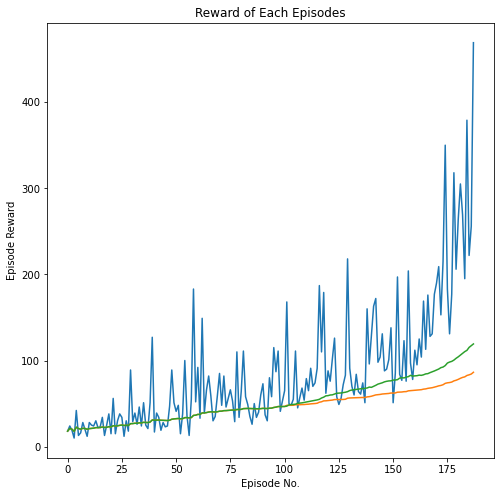

In [12]:
def plot(episode_rewards):
    
    plt.figure(figsize=(8,8))
    
    plt.plot(episode_rewards)
    plt.ylabel('Episode Reward')
    plt.xlabel('Episode No.')
    plt.title('Reward of Each Episodes')
        
    running_avg = [np.average(episode_rewards[:i+1]) for i in range(len(episode_rewards))]
    running_avg_100 = running_avg[:100] + [np.average(episode_rewards[i:i+100]) for i in range(len(episode_rewards)-100)]
    
    plt.plot(running_avg, label='average reward')
    plt.plot(running_avg_100, label='average reward of past 100 episodes')
    plt.show()
    
plot(episode_rewards_shared)
# plot(episode_rewards1)
# plot(episode_rewards2)

## Questions

1. Should actor and critic parameters be shared?
2. Can we predict how much variance reduction we can expect if we batch episodes?
3. How does the choice of loss function affect learning?
4. Do network parameters converge to similar values regardless of initialization? To test this, I need to make sure that the same episodes are sampled across trials.
5. Do network parameters converge to similar values regardless of the ordering of episodes? Again, I need to make sure the same set of episodes are used across trials.
6. Do network parameters converge to simialr values in the long-run, even if initialization is random and if trajectory sampling is random?
7. Why does choosing a random action with epsilon probability cause network weights to explode? Set eps=1 to replicate.